In [156]:
import sys
sys.path.append("/mnt/Data16Tc/home/haichao/code/SpaCon/")
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import torch
import warnings
from tqdm import tqdm
import torch.nn.functional as F
from scipy.stats import pearsonr

from Cluster_Network.utils import Batch_Data_3D, Transfer_pytorch_Data, Transfer_pytorch_NT_Data
from Cluster_Network.adjacency_matrix_calculate import Cal_Spatial_Net_3D, Stats_Spatial_Net
from Cluster_Network.model_pyg import GATE_PyG, GATE_PyG_3Layers, GATE_PyG_3Layers_Encapsulation
from Cluster_Network.r_mcluster import mclust_R
import copy
import datetime
import os
import time
import scipy.sparse as sp
import anndata
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
warnings.filterwarnings("ignore")

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

### Load the Data

In [2]:
# fig_path = "/mnt/Data16Tc/home/haichao/code/SpaCon/ST_NT_cluster/SpaCon_apply_zxw/results/mouse_1/2024_01_20_19_53_22_GATE_3layers/Clusters_res0.75/"
# adata_row = sc.read_h5ad(fig_path+'/adata_cluster_feature.h5ad')
# print('adata_cluster:\n', adata_row)
adata_single_cell = sc.read_h5ad('/mnt/Data16Tc/home/haichao/code/SpaCon/Data/N_20231213_zxw/mouse_3/adata_processed.h5ad')
# add allen region
allen_region = pd.read_csv('/mnt/Data16Tc/home/haichao/code/SpaCon/Data/N_20231213_zxw/mouse_3/allen_region.csv')
adata_single_cell.obs['region'] = allen_region['region'].to_list()
# add cell type
meta = pd.read_csv('/mnt/Data16Tc/home/haichao/code/SpaCon/Data/N_20231213_zxw/mouse_3/cell_metadata_with_cluster_annotation.csv')
meta = meta.set_index('cell_label')
meta = meta.loc[adata_single_cell.obs.index.to_list()]
adata_single_cell.obs['cell_type'] = meta['class'].to_list()
adata_single_cell.obs

,brain_section_label,x,y,z,x_ccf,y_ccf,z_ccf,region,cell_type
cell_label,,,,,,,,,
198904341065180396762707397604803217407,Zhuang-ABCA-3.023,49.206853,44.877634,12.168155,4.920685,4.487763,1.216815,SSs1,33 Vascular
252199681526991424029643077826220097990,Zhuang-ABCA-3.023,48.973992,44.813761,12.179006,4.897399,4.481376,1.217901,SSs1,33 Vascular
277720971126854564514249564750701518375,Zhuang-ABCA-3.023,48.791066,44.577722,12.192707,4.879107,4.457772,1.219271,SSs1,33 Vascular
31551867344111790264292067056219852271,Zhuang-ABCA-3.023,48.830489,44.426120,12.195078,4.883049,4.442612,1.219508,SSs1,33 Vascular
131102494428104399865219008178262036485,Zhuang-ABCA-3.023,48.308843,43.028156,12.267879,4.830884,4.302816,1.226788,SSs1,34 Immune
...,...,...,...,...,...,...,...,...,...
318102106429791409781741726367984532777,Zhuang-ABCA-3.009,131.090716,69.334275,41.436743,13.109072,6.933427,4.143674,MDRNd,30 Astro-Epen
35262847161560382172299767067854387528,Zhuang-ABCA-3.009,131.216032,69.494070,41.351034,13.121603,6.949407,4.135103,MDRNd,33 Vascular
75415866509570969932943497000463821106,Zhuang-ABCA-3.009,131.415152,70.764504,40.800403,13.141515,7.076450,4.080040,sctd,24 MY Glut


In [3]:
adata_single_cell.obsm['spatial'] = adata_single_cell.obs.loc[:, ['z', 'y']].values
adata_single_cell

AnnData object with n_obs × n_vars = 1566842 × 1122
    obs: 'brain_section_label', 'x', 'y', 'z', 'x_ccf', 'y_ccf', 'z_ccf', 'region', 'cell_type'
    obsm: 'spatial'

In [4]:
sc.pp.normalize_total(adata_single_cell, target_sum=1e4)
sc.pp.log1p(adata_single_cell)
adata_single_cell

AnnData object with n_obs × n_vars = 1566842 × 1122
    obs: 'brain_section_label', 'x', 'y', 'z', 'x_ccf', 'y_ccf', 'z_ccf', 'region', 'cell_type'
    uns: 'log1p'
    obsm: 'spatial'

In [5]:
adata_single_cell = adata_single_cell[adata_single_cell.obs['cell_type'].str.contains('Glut')]
adata_single_cell.obs

,brain_section_label,x,y,z,x_ccf,y_ccf,z_ccf,region,cell_type
cell_label,,,,,,,,,
207252950882079766503645227815929952400,Zhuang-ABCA-3.023,50.597984,41.393473,12.239274,5.059798,4.139347,1.223927,SSs2/3,01 IT-ET Glut
311894855078226645952213910865897976013,Zhuang-ABCA-3.023,50.420950,41.271525,12.251970,5.042095,4.127152,1.225197,SSs1,01 IT-ET Glut
125208524519663791324346814779771999476,Zhuang-ABCA-3.023,50.959183,43.276307,12.158869,5.095918,4.327631,1.215887,SSs2/3,01 IT-ET Glut
12594778395225515056477813574460470379,Zhuang-ABCA-3.023,49.836112,42.209685,12.238386,4.983611,4.220968,1.223839,SSs1,01 IT-ET Glut
148621603142722639702356861951538418099,Zhuang-ABCA-3.023,51.023440,42.722536,12.174236,5.102344,4.272254,1.217424,SSs2/3,01 IT-ET Glut
...,...,...,...,...,...,...,...,...,...
235686740179650165428728286428984964004,Zhuang-ABCA-3.009,131.552253,69.048948,41.463859,13.155225,6.904895,4.146386,MDRNd,24 MY Glut
286400092677302831060643120351923719874,Zhuang-ABCA-3.009,131.640659,70.151099,41.013819,13.164066,7.015110,4.101382,rust,24 MY Glut
75415866509570969932943497000463821106,Zhuang-ABCA-3.009,131.415152,70.764504,40.800403,13.141515,7.076450,4.080040,sctd,24 MY Glut


In [6]:
th_regions = ['AD', 'AMd', 'AMv', 'AV', 'CL', 'CM', 'IAD', 'IAM', 'IGL', 'IMD', 'LD', 'LGv', 'LH', 'LP', 'MD', 'MGd', 'MGm', 'MGv', 'MH', 'PCN', 'PF', 'PIL', 'PO', 'POL',
                'PP', 'PR', 'PT', 'PVT', 'PoT', 'RE', 'RH', 'RT', 'SGN', 'SMT', 'SPA', 'SPFm', 'SPFp', 'VAL', 'VM', 'VPL', 'VPLpc', 'VPM', 'VPMpc', 'Xi']
ctx_regions = ['ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp', 'AUDpo',
                'AUDv', 'ECT', 'FRP', 'GU', 'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm',
                'ORBvl', 'PERI', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-bfd',
                'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-tr', 'SSp-ul', 'SSp-un', 'SSs',
                'TEa', 'VISC', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp',
                'VISpl', 'VISpm', 'VISpor', 'VISrl']


In [7]:
adata_sc_ctx_th = adata_single_cell[(adata_single_cell.obs['region'].str.startswith(tuple(ctx_regions))) | (adata_single_cell.obs['region'].isin(th_regions))]
adata_sc_ctx_th

View of AnnData object with n_obs × n_vars = 159751 × 1122
    obs: 'brain_section_label', 'x', 'y', 'z', 'x_ccf', 'y_ccf', 'z_ccf', 'region', 'cell_type'
    uns: 'log1p'
    obsm: 'spatial'

#### ctx layer & th correlation 

In [68]:
correlation_df = pd.DataFrame(dtype=float)

for c in tqdm(ctx_regions):
    adata_ctx = adata_sc_ctx_th[adata_sc_ctx_th.obs['region'].str.startswith(c)]
    l1234_adata = adata_ctx[adata_ctx.obs['region'].str.contains('1|2/3|4')]
    l56_adata = adata_ctx[adata_ctx.obs['region'].str.contains('5|6')]
    l1234_gene_expression = l1234_adata.X.A.T
    l56_gene_expression = l56_adata.X.A.T
    for t in th_regions:
        adata_th = adata_sc_ctx_th[adata_sc_ctx_th.obs['region'] == t]

        if (l1234_adata.shape[0] == 0) | (l56_adata.shape[0] == 0) | (adata_th.shape[0] == 0):
            continue

        th_gene_expression = adata_th.X.A.T  # 取转置将基因表示为行
        
        correlation1234, _ = pearsonr(l1234_gene_expression.mean(axis=1), th_gene_expression.mean(axis=1))
        correlation56, _ = pearsonr(l56_gene_expression.mean(axis=1), th_gene_expression.mean(axis=1))
        correlation_df.loc[c+'L1234', t] = correlation1234
        correlation_df.loc[c+'L56', t] = correlation56

  0%|          | 0/43 [00:00<?, ?it/s]

100%|██████████| 43/43 [00:33<00:00,  1.28it/s]


In [69]:
# correlation_df = correlation_df.dropna()
correlation_df

,AD,AMd,AMv,AV,CL,CM,IAD,IAM,IGL,LD,...,SMT,SPA,SPFm,SPFp,VAL,VM,VPL,VPLpc,VPM,VPMpc
ACAdL1234,0.348581,0.414405,0.410863,0.359889,0.432584,0.420602,0.429009,0.386776,0.365987,0.420700,...,0.376784,0.383056,0.441381,0.448306,0.388026,0.406243,0.370669,0.383025,0.369407,0.454376
ACAdL56,0.417141,0.419654,0.415910,0.392064,0.448785,0.416705,0.424593,0.383480,0.408341,0.447961,...,0.387516,0.418954,0.474857,0.496227,0.415548,0.428184,0.395938,0.393139,0.388435,0.471663
AIdL1234,0.341991,0.398774,0.397407,0.344122,0.418994,0.382235,0.405165,0.353381,0.349071,0.402233,...,0.340099,0.368857,0.438614,0.457679,0.367328,0.395118,0.349740,0.354302,0.345574,0.437611
AIdL56,0.406224,0.422275,0.417833,0.386127,0.453417,0.412838,0.425554,0.383675,0.407391,0.449008,...,0.383948,0.420992,0.484975,0.504638,0.410848,0.427181,0.394207,0.392503,0.385743,0.475945
AIpL1234,0.328339,0.402054,0.397741,0.336678,0.423461,0.383184,0.407490,0.358650,0.334158,0.398961,...,0.344229,0.380874,0.452734,0.455320,0.357355,0.387742,0.344952,0.349769,0.340165,0.436486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VISpmL56,0.396659,0.421552,0.424512,0.390034,0.452046,0.412607,0.427185,0.389750,0.388206,0.447123,...,0.385107,0.414172,0.462998,0.500362,0.409463,0.422706,0.397961,0.393359,0.394643,0.471724
VISporL1234,0.325329,0.406731,0.404251,0.346367,0.427536,0.397535,0.414961,0.366196,0.341407,0.403779,...,0.360420,0.378193,0.449138,0.453036,0.376119,0.406784,0.356590,0.364602,0.352571,0.445923
VISporL56,0.384760,0.416971,0.410797,0.378694,0.445917,0.406963,0.420572,0.379323,0.381953,0.432090,...,0.373922,0.427294,0.488541,0.495476,0.389674,0.413481,0.368775,0.372816,0.361106,0.466464
VISrlL1234,0.375451,0.425371,0.430459,0.383246,0.449832,0.409178,0.429799,0.385970,0.383207,0.435157,...,0.375572,0.390033,0.453511,0.488799,0.406922,0.426857,0.398477,0.390356,0.396003,0.470219


In [70]:
correlation_df = correlation_df.mean(axis=1)
correlation_df

ACAdL1234      0.400598
ACAdL56        0.422850
AIdL1234       0.386156
AIdL56         0.425020
AIpL1234       0.385824
                 ...   
VISpmL56       0.421503
VISporL1234    0.393303
VISporL56      0.415397
VISrlL1234     0.417750
VISrlL56       0.407521
Length: 84, dtype: float64

In [72]:
df_1234 = correlation_df[correlation_df.index.str.contains('1234')].values
df_56 = correlation_df[correlation_df.index.str.contains('56')].values
df_56.shape

(42,)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Layer1/2/3/4 vs. Layer5/6: Brunner-Munzel test, P_val:2.261e-02 W=2.325e+00


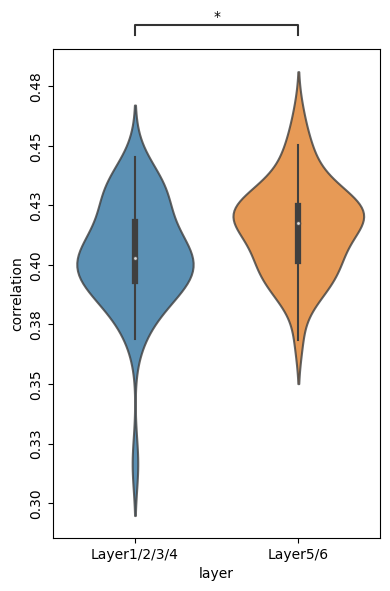

In [164]:
df_long = pd.DataFrame({
    'correlation': np.concatenate((df_1234, df_56)),
    'layer': ['Layer1/2/3/4'] * len(df_1234) + ['Layer5/6'] * len(df_56)
})
df_long['correlation'] = df_long['correlation'].astype('float')
plt.figure(figsize=(4,6))
ax = sns.violinplot(y='correlation', x='layer', data=df_long, orient='v', capsize=0.1)
for violin in ax.collections:
    violin.set_alpha(0.8)
# sns.stripplot(x='correlation', y='layer', data=df_long, ax=ax, color='black', size=5, jitter=0.2, dodge=True, alpha=0.5, edgecolor='#252525', linewidth=0.5, orient='h')
# sns.swarmplot(x='correlation', y='layer', data=df_long, ax=ax, color='black', size=5, dodge=True, alpha=0.5, edgecolor='#252525', linewidth=0.5, orient='h')
# ax.set_xlim(0.36, 0.46)
pairs = [('Layer1/2/3/4', 'Layer5/6')]
from statannotations.Annotator import Annotator
annotator = Annotator(ax, pairs, data=df_long, y='correlation', x='layer', orient='v')
annotator.configure(test='Brunner-Munzel', text_format='star', loc='outside')
annotator.apply_and_annotate()
from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
plt.yticks(rotation=90, va='center')
plt.tight_layout()
plt.savefig('layer_th_corr.pdf', format='pdf')